In [152]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import tree
import graphviz
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [153]:
# 绘图时显示中文
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 数据清洗
数据集里不包含空数据，但包含大量无效数据，通常取 99 98 97 来代指无效数据，因此此处清洗数据，以便展开后续工作。
<br>下列标签的取值只有取 1 和 2 时是有效的，因此此处只保留取 1 和 2 的取值，其他取值全部抛弃。
<br>特别要注意的是，死亡日期取 9999-99-99 并不代指无效数据，而代指未死亡，为了方便后续处理，以 1 代指患者死亡，以 2 代指患者存活。

In [154]:
df = pd.read_csv("Covid Data.csv")

# 数据清洗
# 部分标签包含取值 99 98 97 代表无效数据
# 这一步是清除掉值不是有效取值的单元
df = df[(df.PNEUMONIA == 1) | (df.PNEUMONIA == 2)]
df = df[(df.DIABETES == 1) | (df.DIABETES == 2)]
df = df[(df.COPD == 1) | (df.COPD == 2)]
df = df[(df.ASTHMA == 1) | (df.ASTHMA == 2)]
df = df[(df.INMSUPR == 1) | (df.INMSUPR == 2)]
df = df[(df.HIPERTENSION == 1) | (df.HIPERTENSION == 2)]
df = df[(df.OTHER_DISEASE == 1) | (df.OTHER_DISEASE == 2)]
df = df[(df.CARDIOVASCULAR == 1) | (df.CARDIOVASCULAR == 2)]
df = df[(df.OBESITY == 1) | (df.OBESITY == 2)]
df = df[(df.RENAL_CHRONIC == 1) | (df.RENAL_CHRONIC == 2)]
df = df[(df.TOBACCO == 1) | (df.TOBACCO == 2)]

df['DEAD'] = [2 if i == '9999-99-99' else 1 for i in df.DATE_DIED]
# 移除死亡日期
df.drop(columns=['DATE_DIED'], inplace=True)

In [155]:
# 训练时取前50000个元素进行训练，效果较好
df = df.head(50000)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 50988
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   USMER                 50000 non-null  int64
 1   MEDICAL_UNIT          50000 non-null  int64
 2   SEX                   50000 non-null  int64
 3   PATIENT_TYPE          50000 non-null  int64
 4   INTUBED               50000 non-null  int64
 5   PNEUMONIA             50000 non-null  int64
 6   AGE                   50000 non-null  int64
 7   PREGNANT              50000 non-null  int64
 8   DIABETES              50000 non-null  int64
 9   COPD                  50000 non-null  int64
 10  ASTHMA                50000 non-null  int64
 11  INMSUPR               50000 non-null  int64
 12  HIPERTENSION          50000 non-null  int64
 13  OTHER_DISEASE         50000 non-null  int64
 14  CARDIOVASCULAR        50000 non-null  int64
 15  OBESITY               50000 non-null  int64
 16  RENA

# 特征分析
在开始训练之前，我们需要分析一些特征与死亡的关系。

In [156]:
for i in df.columns:
    df_temp = df[(df[i] == 99) | (df[i] == 97) | (df[i] == 98)]
    print(i + " : ",df_temp[i].count())

USMER :  0
MEDICAL_UNIT :  0
SEX :  0
PATIENT_TYPE :  0
INTUBED :  17594
PNEUMONIA :  0
AGE :  50
PREGNANT :  28795
DIABETES :  0
COPD :  0
ASTHMA :  0
INMSUPR :  0
HIPERTENSION :  0
OTHER_DISEASE :  0
CARDIOVASCULAR :  0
OBESITY :  0
RENAL_CHRONIC :  0
TOBACCO :  0
CLASIFFICATION_FINAL :  0
ICU :  17605
DEAD :  0


可以发现，标签 INTUBED、PREGNANT、ICU 都包含了大量的无效数据，也即取值为 99、98、97，因此我们需要舍弃这三类标签。

## 年龄
可视化年龄分布与不同年龄段下的死亡率。

Text(0.5, 1.0, '患者的年龄分布')

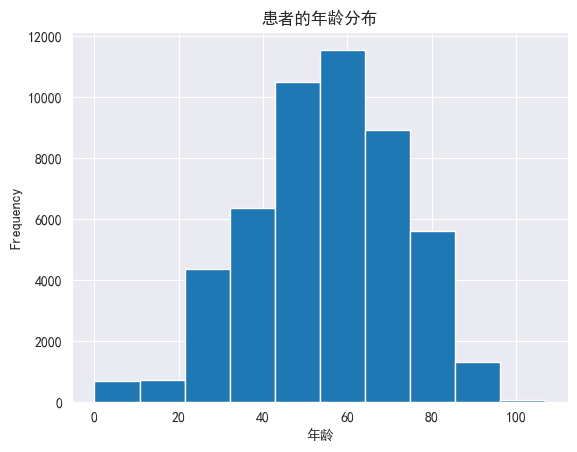

In [157]:
df['AGE'].plot(kind='hist')
plt.xlabel("年龄")
plt.title("患者的年龄分布")

Text(0, 0.5, '年龄')

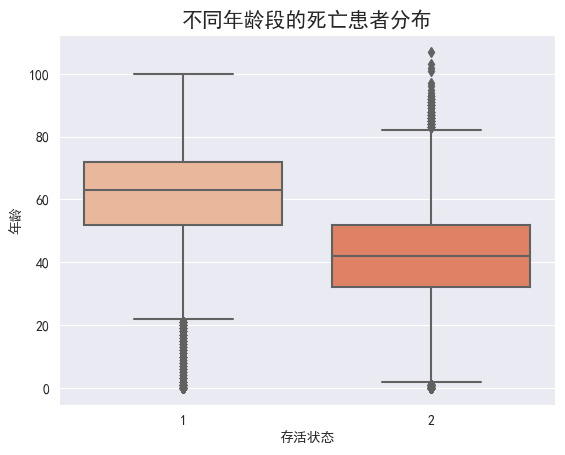

In [158]:
sns.boxplot(x="DEAD", y="AGE",data=df,palette=sns.color_palette("rocket_r"))
plt.title("不同年龄段的死亡患者分布",fontsize=15)
plt.xlabel("存活状态")
plt.ylabel("年龄")

由上图可以总结出几点特征：
* 大多数死亡患者年龄通常在 50 到 70 岁之间。
* 有部分死亡患者年龄在 0 到 20 岁之间。
* 大多数存活患者年龄通常在 30 到 50 岁之间。

## 性别
可视化不同性别、年龄分布下的死亡率，注意，只包含两种性别。

Text(0, 0.5, '年龄')

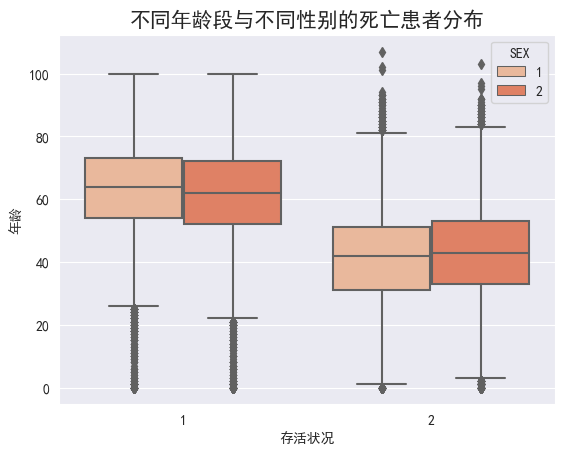

In [159]:
sns.boxplot(x="DEAD", y="AGE",data=df,palette=sns.color_palette("rocket_r"), hue='SEX')
plt.title("不同年龄段与不同性别的死亡患者分布",fontsize=15)
plt.xlabel("存活状况")
plt.ylabel("年龄")

由上图可以发现，两大性别的死亡率差别并不是很大。

## 新冠检测结果
测试不同结果下的死亡率分布。

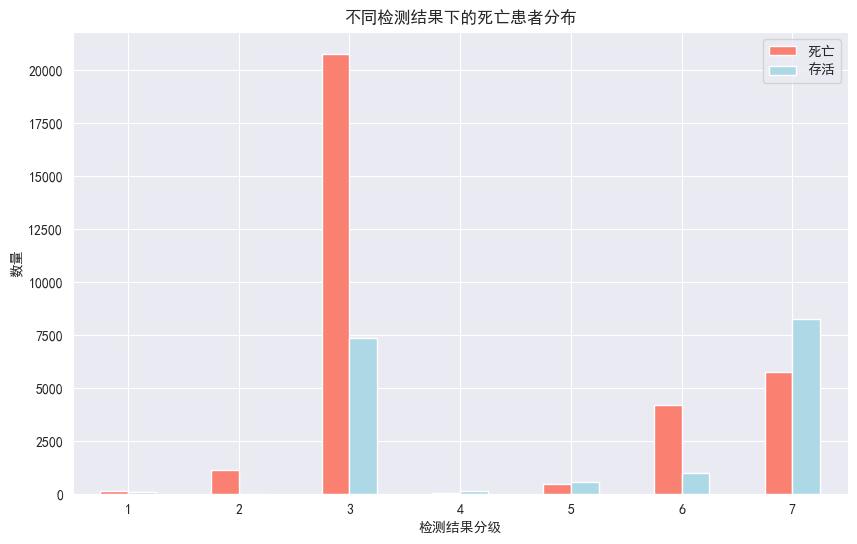

In [160]:
pd.crosstab(df.CLASIFFICATION_FINAL, df.DEAD).plot(kind="bar", figsize=(10,6), color=["salmon","lightblue"])
plt.title("不同检测结果下的死亡患者分布")
plt.xlabel("检测结果分级")
plt.ylabel("数量")
plt.legend(["死亡", "存活"])
plt.xticks(rotation=0);

可以发现，如果新冠检测结果为 7，那么患者存活率要高一点，而取值为 3 的患者死亡率偏高。

## 糖尿病
判断糖尿病患者和非糖尿病患者的死亡率分布。

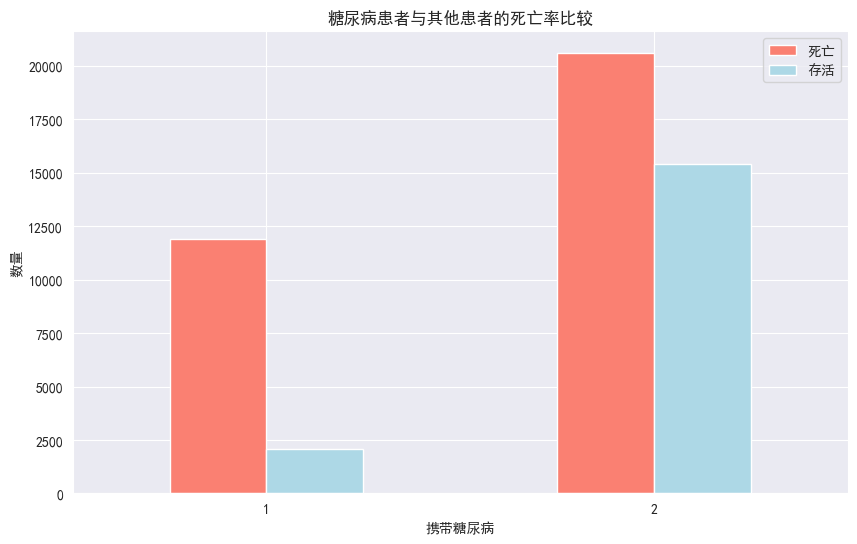

In [161]:
pd.crosstab(df.DIABETES, df.DEAD).plot(kind="bar", figsize=(10,6), color=["salmon","lightblue"])
plt.title("糖尿病患者与其他患者的死亡率比较")
plt.xlabel("携带糖尿病")
plt.ylabel("数量")
plt.legend(["死亡", "存活"])
plt.xticks(rotation=0);

可以发现携带糖尿病的新冠患者死亡风险比不携带的患者要高不少。

## 哮喘
比较哮喘患者和普通患者的死亡率分布。

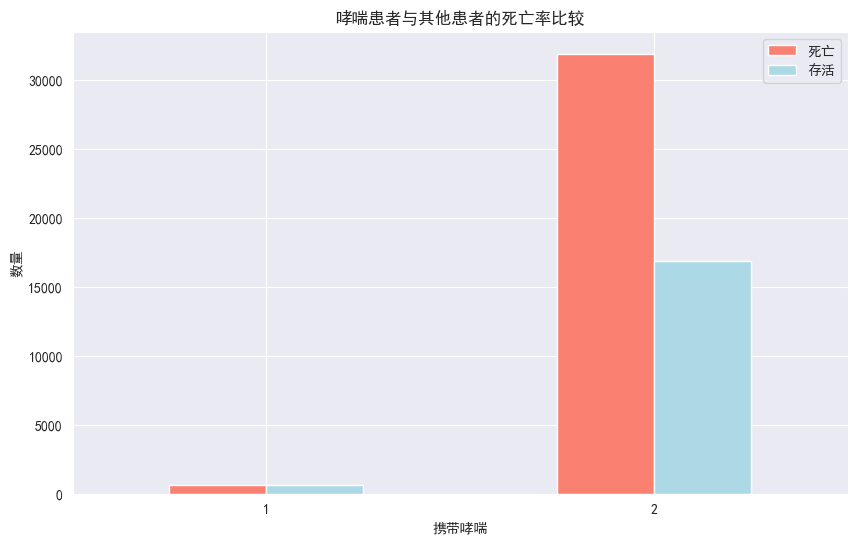

In [162]:
pd.crosstab(df.ASTHMA, df.DEAD).plot(kind="bar", figsize=(10,6), color=["salmon","lightblue"])
plt.title("哮喘患者与其他患者的死亡率比较")
plt.xlabel("携带哮喘")
plt.ylabel("数量")
plt.legend(["死亡", "存活"])
plt.xticks(rotation=0);

可以发现该数据集下哮喘患者死亡率比普通患者低，这不太符合常规认识。根据分析，发现是选取的数据集包含的哮喘患者过少，因此导致了哮喘患者死亡率低于普通患者。

## 肺炎
比较肺炎患者和普通患者的死亡率分布。

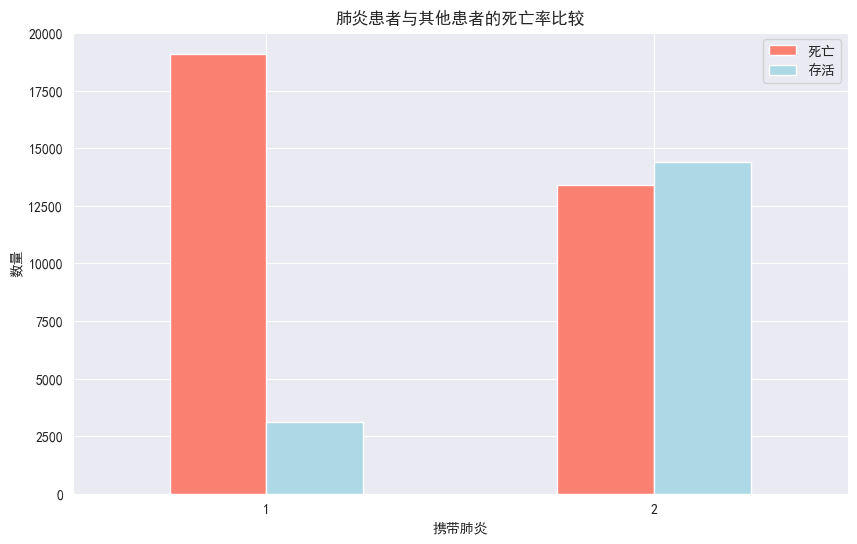

In [163]:
pd.crosstab(df.PNEUMONIA, df.DEAD).plot(kind="bar", figsize=(10,6), color=["salmon","lightblue"])
plt.title("肺炎患者与其他患者的死亡率比较")
plt.xlabel("携带肺炎")
plt.ylabel("数量")
plt.legend(["死亡", "存活"])
plt.xticks(rotation=0);

可以发现肺炎患者死亡率要高于普通患者。

# 筛选特征

In [164]:
corr_matrix = df.corr()
corr_matrix

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,...,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU,DEAD
USMER,1.000000,-0.026553,0.008388,-0.104630,0.106901,0.055807,-0.020112,0.008150,0.012637,0.003311,...,-0.005004,0.008779,-0.007543,-0.007164,-0.027391,0.016488,-0.005499,0.027249,0.106636,0.024304
MEDICAL_UNIT,-0.026553,1.000000,0.150854,0.697985,-0.686029,-0.328344,0.482783,0.150412,-0.239515,-0.113939,...,-0.066159,-0.262369,-0.124798,-0.080480,-0.048537,-0.127100,-0.036467,-0.240801,-0.684821,-0.913112
SEX,0.008388,0.150854,1.000000,0.143151,-0.140571,-0.086729,0.063986,0.999164,0.012217,0.006631,...,0.013958,0.016811,0.013237,-0.010949,0.034902,-0.005129,-0.114523,-0.075856,-0.140321,-0.164449
PATIENT_TYPE,-0.104630,0.697985,0.143151,1.000000,-0.979400,-0.466499,0.445339,0.143092,-0.245217,-0.096931,...,-0.069801,-0.255068,-0.113465,-0.084309,-0.033011,-0.119966,-0.026036,-0.237452,-0.978936,-0.762682
INTUBED,0.106901,-0.686029,-0.140571,-0.979400,1.000000,0.465436,-0.436885,-0.140526,0.240543,0.094221,...,0.070689,0.246817,0.111575,0.080502,0.027292,0.118624,0.028076,0.228058,0.999454,0.744273
PNEUMONIA,0.055807,-0.328344,-0.086729,-0.466499,0.465436,1.000000,-0.254659,-0.086681,0.153163,0.052373,...,0.043653,0.151141,0.054733,0.049708,0.042520,0.053361,0.027443,0.244660,0.464900,0.392893
AGE,-0.020112,0.482783,0.063986,0.445339,-0.436885,-0.254659,1.000000,0.063437,-0.263996,-0.173785,...,0.005617,-0.352867,-0.060184,-0.127459,0.001378,-0.064992,-0.040715,-0.182301,-0.436798,-0.523417
PREGNANT,0.008150,0.150412,0.999164,0.143092,-0.140526,-0.086681,0.063437,1.000000,0.012246,0.006793,...,0.014097,0.016934,0.013444,-0.010779,0.034984,-0.005090,-0.114296,-0.075659,-0.140278,-0.163996
DIABETES,0.012637,-0.239515,0.012217,-0.245217,0.240543,0.153163,-0.263996,0.012246,1.000000,0.084099,...,0.061122,0.392756,0.026704,0.099353,0.092969,0.202673,0.030075,0.097043,0.240426,0.263098
COPD,0.003311,-0.113939,0.006631,-0.096931,0.094221,0.052373,-0.173785,0.006793,0.084099,1.000000,...,0.054424,0.114894,0.030668,0.111051,0.038772,0.054846,0.107475,0.000203,0.094423,0.118564


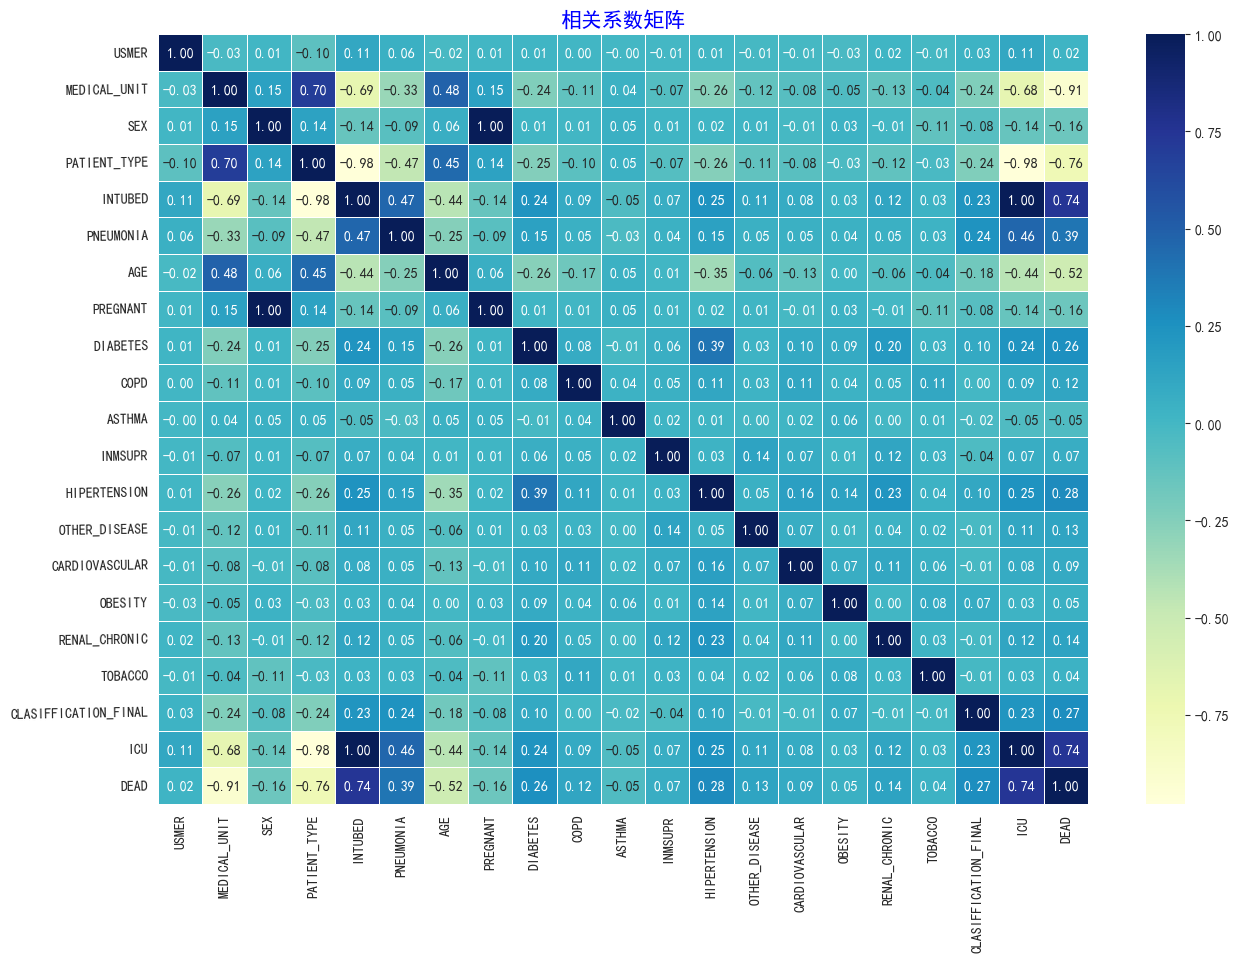

In [165]:
fig, axe = plt.subplots(figsize=(15,10))
sns.heatmap(corr_matrix,
                annot=True,
                linewidths=0.5,
                fmt=".2f",
                cmap="YlGnBu")
plt.yticks(rotation=1)
plt.title("相关系数矩阵", fontsize=15, c='blue');

接下来选择与 DEAD 特征（也就是死亡特征）相关系数大于 0.2 的特征，但 DEAD 以及三大包含大量无效数据的特征需要排除在外。

In [166]:
cor_target = abs(corr_matrix["DEAD"])
features_selected = cor_target[cor_target>0.2]
features_selected

MEDICAL_UNIT            0.913112
PATIENT_TYPE            0.762682
INTUBED                 0.744273
PNEUMONIA               0.392893
AGE                     0.523417
DIABETES                0.263098
HIPERTENSION            0.284453
CLASIFFICATION_FINAL    0.267416
ICU                     0.743177
DEAD                    1.000000
Name: DEAD, dtype: float64

所以，可以确定的特征为：MEDICAL_UNIT、PATIENT_TYPE、AGE、PNEUMONIA、HIPERTENSION、CLASIFFICATION_FINAL、DIABETES
这是因为这些特征与 DEAD 的相关系数均大于 0.2 ，有较强的关联性（同时他们每个的量也足够多）

In [167]:
# CLASIFFICATION_FINAL 为原标签，请勿修改此处拼写
X = df[['MEDICAL_UNIT', 'PATIENT_TYPE', 'AGE', 'PNEUMONIA', 'HIPERTENSION', 'CLASIFFICATION_FINAL', 'DIABETES']]
y = df['DEAD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# 效果可视化
不断增加最大深度，检查效果，选择合适的最大深度。

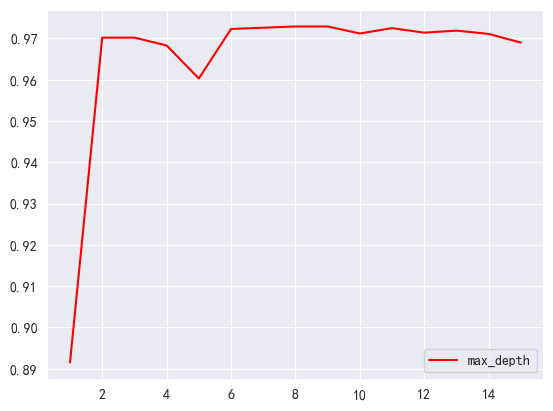

In [168]:
# 决策树 信息熵
test_entropy = []
for i in range(1, 16):
    dte = tree.DecisionTreeClassifier(max_depth=i
                                      , criterion="entropy"
                                      , random_state=30
                                      , splitter="random"
                                      )
    dte = dte.fit(X_train, y_train)
    score_e = dte.score(X_test, y_test)
    test_entropy.append(score_e)
plt.plot(range(1, 16), test_entropy, color="red", label="max_depth")
plt.legend()
plt.show()

根据生成的图 确定最大深度取 10 较为合适

In [169]:
# 建树 使用信息熵
# 根据生成的图 确定最大深度取10较为合适
dte = tree.DecisionTreeClassifier(criterion = 'entropy',max_depth=10)
dte = dte.fit(X_train,y_train)
score_entropy = dte.score(X_test,y_test)

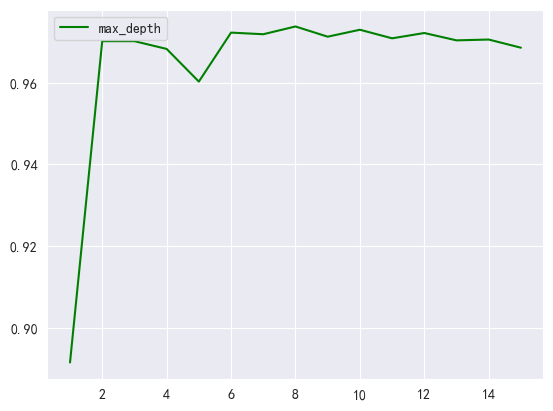

In [170]:
# 决策树 基尼系数
test_gini = []
for i in range(1, 16):
    dtg = tree.DecisionTreeClassifier(max_depth=i
                                      , criterion="gini"
                                      , random_state=30
                                      , splitter="random"
                                      )
    dtg = dtg.fit(X_train, y_train)
    score_g = dtg.score(X_test, y_test)
    test_gini.append(score_g)
plt.plot(range(1, 16), test_gini, color="green", label="max_depth")
plt.legend()
plt.show()

根据生成的图 确定最大深度取 10 较为合适

In [171]:
# 基尼系数 建树 根据生成的图 取10最大深度较为合适
dtg = tree.DecisionTreeClassifier(criterion = 'gini',max_depth=10)
dtg = dtg.fit(X_train,y_train)
score_gini = dtg.score(X_test,y_test)

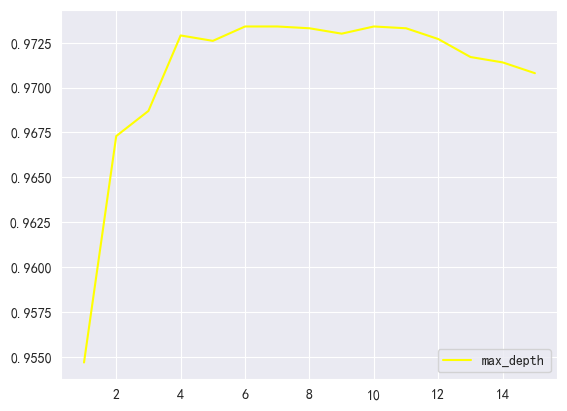

In [172]:
# 随机森林
test_rf = []
for i in range(1, 16):
    rf = RandomForestClassifier(max_depth=i
                                      , criterion="entropy"
                                      , random_state=30
                                      )
    rf = rf.fit(X_train, y_train)
    score_rf = rf.score(X_test, y_test)
    test_rf.append(score_rf)
plt.plot(range(1, 16), test_rf, color="yellow", label="max_depth")
plt.legend()
plt.show()

根据生成的图 确定最大深度取 8 较为合适

In [173]:
rf = RandomForestClassifier(max_depth=8, criterion="entropy", random_state=30)
rf = rf.fit(X_train, y_train)
score_rf = rf.score(X_test, y_test)

## 决策树可视化
此处将可视化两棵决策树，并将其保存在 __Entropy.pdf__ 与 __Gini.pdf__ 后自动打开。

In [188]:
# 可视化树
# 此处会打开 2 个 PDF 并且保存于本地
# 信息熵
feature_name = X.columns.tolist()
dot_data1 = tree.export_graphviz(dte
                                ,feature_names=feature_name
                                ,filled=True
                                ,rounded=True)
graph1 = graphviz.Source(dot_data1)
graph1.render('Entropy')
graph1.view()
# 基尼系数
dot_data2 = tree.export_graphviz(dtg
                                ,feature_names=feature_name
                                ,filled=True
                                ,rounded=True)
graph2 = graphviz.Source(dot_data2)
graph2.render('Gini')
graph2.view()

'Gini.pdf'

In [175]:
[*zip(feature_name,dte.feature_importances_)]

[('MEDICAL_UNIT', 0.9054194736732442),
 ('PATIENT_TYPE', 0.06045887304518368),
 ('AGE', 0.01902221818195181),
 ('PNEUMONIA', 0.007109966746790295),
 ('HIPERTENSION', 0.0009643443875609659),
 ('CLASIFFICATION_FINAL', 0.005814667301609775),
 ('DIABETES', 0.0012104566636594687)]

### 效果分析

In [176]:
dte_pred = dte.predict(X_test)
dtg_pred = dtg.predict(X_test)
rf_pred = rf.predict(X_test)

In [177]:
score_test_entropy = dte.score(X_test,y_test)
print("信息熵策略：")
score_test_entropy

信息熵策略：


0.9721

In [178]:
score_test_gini = dtg.score(X_test, y_test)
print("基尼系数策略：")
score_test_gini

基尼系数策略：


0.9718

In [179]:
score_test_rf = rf.score(X_test, y_test)
print("随机森林：")
score_test_rf

随机森林：


0.9733

In [180]:
print("----------------")
print("信息熵")
print(classification_report(y_test, dte_pred))
print("----------------")
print("基尼系数")
print(classification_report(y_test, dtg_pred))
print("----------------")
print("随机森林")
print(classification_report(y_test, rf_pred))

----------------
信息熵
              precision    recall  f1-score   support

           1       0.98      0.97      0.98      6534
           2       0.95      0.97      0.96      3466

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

----------------
基尼系数
              precision    recall  f1-score   support

           1       0.98      0.97      0.98      6534
           2       0.95      0.97      0.96      3466

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

----------------
随机森林
              precision    recall  f1-score   support

           1       0.99      0.97      0.98      6534
           2       0.95      0.98      0.96      3466

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted 

## 结果可视化

[[6352  182]
 [  97 3369]]
      0     1
0  6352   182
1    97  3369


Text(52.722222222222214, 0.5, '真实')

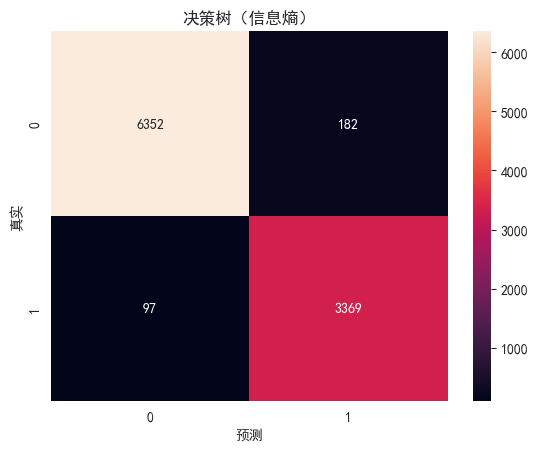

In [181]:
# 信息熵 混淆矩阵
cm_entropy = confusion_matrix(y_test, dte_pred, labels=[1, 2])

print(cm_entropy)
df_cm_entropy = pd.DataFrame(cm_entropy)
print(df_cm_entropy)
ax = sns.heatmap(df_cm_entropy,annot=True,fmt='.20g')
ax.set_title('决策树（信息熵）')
ax.set_xlabel('预测')
ax.set_ylabel('真实')

[[6358  176]
 [ 106 3360]]
      0     1
0  6358   176
1   106  3360


Text(52.722222222222214, 0.5, '真实')

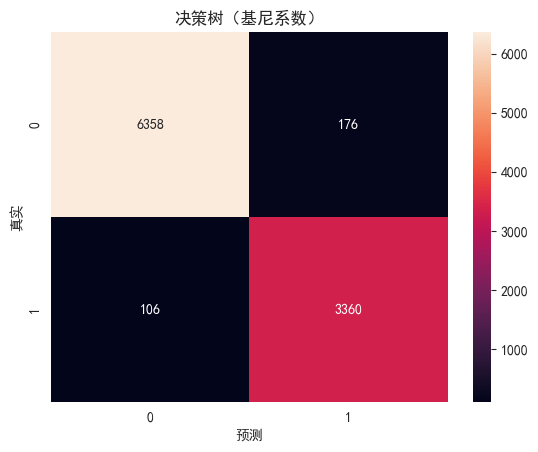

In [182]:
# 基尼系数 混淆矩阵
cm_gini = confusion_matrix(y_test, dtg_pred, labels=[1, 2])

print(cm_gini)
df_cm_gini = pd.DataFrame(cm_gini)
print(df_cm_gini)
ax = sns.heatmap(df_cm_gini,annot=True,fmt='.20g')
ax.set_title('决策树（基尼系数）')
ax.set_xlabel('预测')
ax.set_ylabel('真实')

[[6351  183]
 [  84 3382]]
      0     1
0  6351   183
1    84  3382


Text(52.722222222222214, 0.5, '真实')

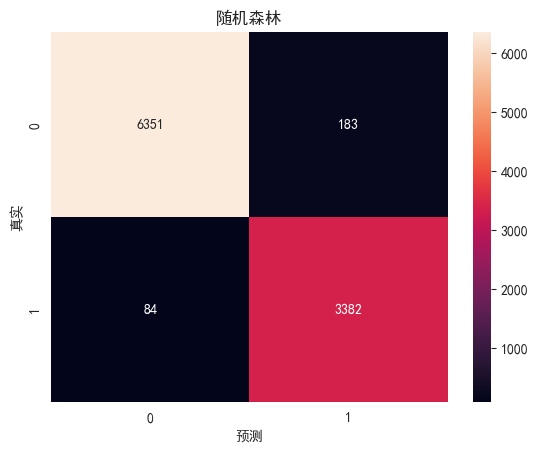

In [183]:
# 随机森林
cm_rf = confusion_matrix(y_test, rf_pred, labels=[1, 2])

print(cm_rf)
df_cm_rf = pd.DataFrame(cm_rf)
print(df_cm_rf)
ax = sns.heatmap(df_cm_rf,annot=True,fmt='.20g')
ax.set_title('随机森林')
ax.set_xlabel('预测')
ax.set_ylabel('真实')